In [15]:
from functools import partial
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
from scipy.optimize import curve_fit
from emcee import EnsembleSampler

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
from src.blockmat import BlockMatrix, BlockVector
import src.inference as INF
from anstey.generate import T_CMB

RS = SH.RealSphericalHarmonics()

In [18]:
def cm21_mod(nuarr, *theta_21):
    A21, nu0, dnu = theta_21
    cm21_a00_terms = np.sqrt(4*np.pi) * A21 * np.exp(-.5*((nuarr-nu0)/dnu)**2)
    return cm21_a00_terms

def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**(-alpha) * np.exp(np.sum(exponent, 0))
    return fg_a00_terms + np.sqrt(4*np.pi)*T_CMB

def fg_cm21_polymod(nuarr, *theta):
    theta_fg = theta[:-3]
    theta_21 = theta[-3:]
    return fg_polymod(nuarr, *theta_fg) + cm21_mod(nuarr, *theta_21)

def gsma_corr(lmod, lmax, nside, nuarr, bmerr):
    """
    Compute and return the GSMA error instance alm mean correction and covariance
    matrix, truncated as requested. Will first check to see if the relevant 
    correction has not already been generated, in which case it will be loaded
    instead.
    """
    Nlmod = RS.get_size(lmod)
    while True:
        try:
            alm_cov  = np.load("saves/gsma_corr_nside<{}>_lmax<{}>_bmerr<{}>_cov.npy".format(nside, lmax, bmerr))
            alm_cov  = alm_cov[:,Nlmod:,Nlmod:]
            alm_mean = np.load("saves/gsma_corr_nside<{}>_lmax<{}>_bmerr<{}>_mean.npy".format(nside, lmax, bmerr))
            alm_mean = alm_mean[:,Nlmod:]
            alm_mean = alm_mean.flatten()
            s = "Loaded mean and covar correction for nside<{}>_lmax<{}>_bmerr<{}>"
            print(s.format(nside, lmax, bmerr))
            return alm_mean, BlockMatrix(mat=alm_cov)
        except:
            s = "Failed loading mean and covar correction for nside<{}>_lmax<{}>_bmerr<{}>, generating instead."
            print(s.format(nside, lmax, bmerr))
        
            gsma_maps = SM.foreground_gsma_nsidelo(nu=nuarr, nside=nside)
            delta = SM.basemap_err_to_delta(percent_err=bmerr)

            temp_cov_blocks = []
            temp_mean_blocks = []

            for nu, gsma_map in zip(nuarr, gsma_maps):
                sigma_T   = delta * np.log(408/nu)

                exponents = np.exp(2*sigma_T**2) - np.exp(sigma_T**2)
                temp_cov_block_diag = exponents*(gsma_map - T_CMB)**2
                temp_cov_blocks.append(np.diag(temp_cov_block_diag))
                temp_mean_block = (gsma_map - T_CMB) * np.exp(sigma_T**2/2) + T_CMB
                temp_mean_blocks.append(temp_mean_block)

            inv_Y = np.linalg.pinv(SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax))
            alm_mean = [inv_Y @ temp_mean_block for temp_mean_block in temp_mean_blocks]
            alm_cov  = [inv_Y @ temp_cov_block @ inv_Y.T for temp_cov_block in temp_cov_blocks]
            np.save("saves/gsma_corr_nside<{}>_lmax<{}>_bmerr<{}>_cov.npy".format(nside, lmax, bmerr), np.array(alm_cov))
            np.save("saves/gsma_corr_nside<{}>_lmax<{}>_bmerr<{}>_mean.npy".format(nside, lmax, bmerr), np.array(alm_mean))

In [20]:
Npoly=4
lats=np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
chrom=None
basemap_err=5
err_type='idx'
mcmc=True
mcmc_pos=None
savetag=""
numerical_corr=False
steps=20000
burn_in=3000
"""
A memory-friendly version of nontrivial_obs which computes the reconstruction
of each frequency seperately, then brings them all together.
"""
# Model and observation params
nside   = 32
lmax    = 32
lmod    = 3
Nlmax   = RS.get_size(lmax)
Nlmod   = RS.get_size(lmod)
if lats is None:
    lats = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])#np.linspace(-80, 80, 100)#
times = np.linspace(0, 24, 12, endpoint=False)#np.linspace(0, 24, 144, endpoint=False)  # 144 = 10 mins per readout
nuarr = np.linspace(50,100,51)
cm21_params     = (-0.2, 80.0, 5.0)
narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)

# Generate foreground and 21-cm signal alm
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type=err_type, seed=100, meancorr=False)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix for the modelling and for the observations.
if chrom is not None:
    if not isinstance(chrom, bool):
        chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    else:
        chromfunc = BF.fwhm_func_tauscher
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmax, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
    mat_A_mod = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(nuarr, nside, lmod, lats=lats, times=times, return_mat=False, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc)
elif chrom is None:
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
    mat_A_mod = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmod, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
    mat_A_mod = BlockMatrix(mat=mat_A_mod, mode='block', nblock=len(nuarr))

# Perform fiducial observations
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, 1, Ntau=len(times), t_int=100, seed=456)#t_int=100, seed=456)#
sample_noise = np.sqrt(noise_covar.block[0][0,0])
print(f"Data generated with noise {sample_noise} K at 50 MHz in the first bin")

# Calculate the missing-modes observation matrix.
mat_A_unmod = BlockMatrix(mat_A.block[:,:,Nlmod:])

# Generate a missing-modes correction numerically by generating instances of 
# the GSMA and finding the mean and covariance.
if numerical_corr:
    fg_alm_list = []
    for i in range(100):
        if err_type=='idx':
            fg_alm_list.append(SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=SM.basemap_err_to_delta(basemap_err), err_type=err_type, seed=123+i, meancorr=False))
        else:
            fg_alm_list.append(SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, delta=basemap_err, err_type=err_type, seed=123+i))
    fg_alm_arr = np.array(fg_alm_list)
    fg_alm_arr = np.array(np.split(fg_alm_arr, len(nuarr), axis=1))
    fg_alm_unmod_arr  = fg_alm_arr[:,:,Nlmod:]
    # Step 3: Compute the data correction and covariance correction.
    data_corr  = []
    covar_corr = []
    for alm_block, mat_A_unmod_block in zip(fg_alm_unmod_arr, mat_A_unmod.block):
        alm_block_mean = np.mean(alm_block, axis=0)
        alm_block_cov  = np.cov(alm_block, rowvar=False)
        data_corr.append(mat_A_unmod_block @ alm_block_mean)
        covar_corr.append(mat_A_unmod_block @ alm_block_cov @ mat_A_unmod_block.T)
    data_corr = BlockVector(np.array(data_corr))
    covar_corr = BlockMatrix(np.array(covar_corr))

# Generate a missing-modes correction analytically.
elif not numerical_corr:
    alm_mean, alm_cov = gsma_corr(lmod, lmax, nside, nuarr, basemap_err)
    data_corr = mat_A_unmod @ alm_mean
    covar_corr = mat_A_unmod @ alm_cov @ mat_A_unmod.T

# Reconstruct the max likelihood estimate of the alm
mat_W, cov = MM.calc_ml_estimator_matrix(mat_A=mat_A_mod, mat_N=noise_covar+covar_corr, cov=True, cond=True)

alm_error = np.sqrt(cov.diag)
rec_alm = mat_W @ (dnoisy - data_corr)
# Compute the chi-square and compare it to the length of the data vector.
chi_sq = ((dnoisy - data_corr) - mat_A_mod@rec_alm).T @ noise_covar.inv @ ((dnoisy - data_corr) - mat_A_mod@rec_alm)
chi_sq = sum(chi_sq.diag)
print("Chi-square:", chi_sq, "len(data):", dnoisy.vec_len,"+/-", np.sqrt(2*dnoisy.vec_len), "Nparams:", Nlmod*len(nuarr))

rec_a00 = np.array(rec_alm.vector[::Nlmod])

# Extract the monopole component of the reconstructed alm.
a00_error = np.array(alm_error[::Nlmod])

# Fit the reconstructed a00 component with a polynomial and 21-cm gaussian
fg_mon_p0 = [15, 2.5]
fg_mon_p0 += [.001]*(Npoly-2)
cm21_mon_p0 = [-0.2, 80, 5]
res = curve_fit(f=fg_cm21_polymod, xdata=nuarr, ydata=rec_a00, sigma=a00_error, p0=fg_mon_p0+cm21_mon_p0)

#_plot_results(nuarr, Nlmax, Nlmod, rec_alm.vector, alm_error, fid_alm, cm21_alm, res)

if mcmc:
    def mod(theta):
        return fg_cm21_polymod(nuarr, *theta)
    
    # create a small ball around the MLE to initialize each walker
    nwalkers, fg_dim = 64, Npoly+3
    ndim = fg_dim
    if mcmc_pos is not None:
        pos = mcmc_pos*(1 + 1e-4*np.random.randn(nwalkers, ndim))
    else:
        pos = res[0]*(1 + 1e-4*np.random.randn(nwalkers, ndim))
    priors = [[1, 25], [1.5, 3.5]]
    priors += [[-2, 2.1]]*(Npoly-2)
    priors += [[-0.5, -0.01], [70, 90], [1, 8]]
    priors = np.array(priors)
    # run emcee without priors
    sampler = EnsembleSampler(nwalkers, ndim, INF.log_posterior, 
                        args=(rec_a00, a00_error, mod, priors))
    _=sampler.run_mcmc(pos, nsteps=steps, progress=True, skip_initial_state_check=True)
    chain_mcmc = sampler.get_chain(flat=True, discard=burn_in)

    prestr = f"Nant<{len(lats)}>_Npoly<{Npoly}>_"
    if chrom is None:
        prestr += "achrom_"
    else:
        prestr += "chrom<{:.1e}>_".format(chrom)
    if basemap_err is not None:
        prestr += err_type+"<{}>_".format(basemap_err)

    np.save("saves/MLmod/"+prestr+savetag+"mcmcChain.npy", chain_mcmc)
    
    # Calculate the BIC for MCMC.    
    c = ChainConsumer()
    c.add_chain(chain_mcmc, statistics='max')
    analysis_dict = c.analysis.get_summary(squeeze=True)
    theta_max = np.array([val[1] for val in analysis_dict.values()])
    loglike = INF.log_likelihood(theta_max, y=rec_a00, yerr=a00_error, model=mod)
    bic = len(theta_max)*np.log(len(rec_a00)) - 2*loglike
    print("bic is ", bic)
    np.save("saves/MLmod/"+prestr+savetag+"bic.npy", bic)

    # Calculate the total model residuals and save them for plotting.
    np.save("saves/MLmod/"+prestr+savetag+"modres.npy", ((dnoisy-data_corr) - mat_A_mod@rec_alm).vector)
    np.save("saves/MLmod/"+prestr+savetag+"data.npy", dnoisy.vector)
    np.save("saves/MLmod/"+prestr+savetag+"dataerr.npy", np.sqrt(noise_covar.diag+covar_corr.diag))


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
Data generated with noise 0.04977088119252106 K at 50 MHz in the first bin
Loaded mean and covar correction for nside<32>_lmax<32>_bmerr<5>
1/condition #: 0.00013098086338785982
Chi-square: 32526538.547775805 len(data): 4284 +/- 92.56349172324907 Nparams: 816


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:40<00:00, 198.55it/s]


bic is  34.79981125824939


In [21]:
dnoisy

(84,) x 51 BlockVector

In [22]:
data_corr

(84,) x 51 BlockVector

In [23]:
mat_A_mod@rec_alm

(84,) x 51 BlockVector

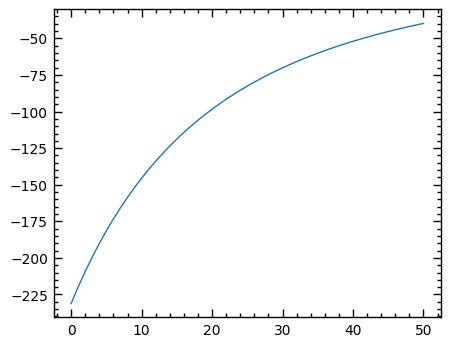

In [30]:
plt.plot(data_corr.vector[::84])

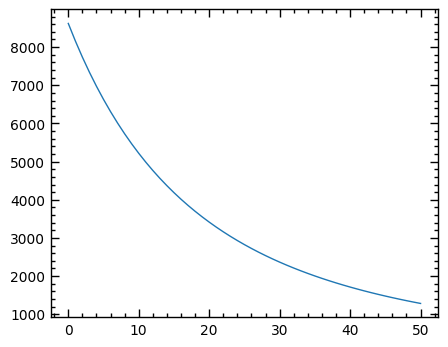

In [31]:
plt.plot(dnoisy.vector[::84])

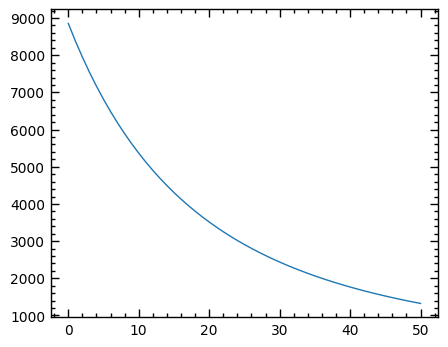

In [34]:
plt.plot((mat_A_mod@rec_alm).vector[::84])

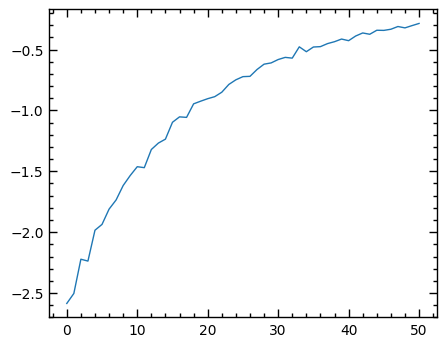

In [35]:
plt.plot(dnoisy.vector[::84]-data_corr.vector[::84]-(mat_A_mod@rec_alm).vector[::84])

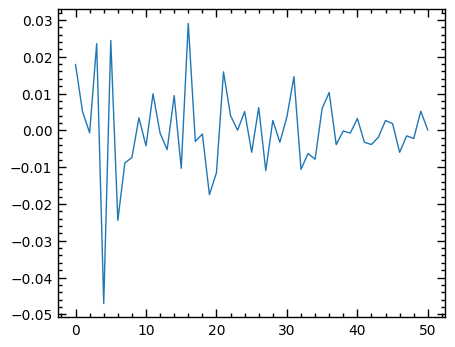

In [44]:
plt.plot(rec_a00-mod(np.mean(chain_mcmc, axis=0)))

In [42]:
np.mean(chain_mcmc, axis=0).shape

(7,)